# 패션 MNIST을 이용해 GCGAN모델로 새로운 이미지 생성하기

## 데이터 전처리
---

In [1]:
# 작업 폴더 생성
! mkdir -p ~/aiffel/dcgan_newimage/fashion/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/fashion/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/fashion/training_history

In [2]:
# 필요한 라이브러리 가져오기
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [3]:
# 데이터셋 가져오기

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data() # '_' 해당 위치에 반환되는 값 무시

In [4]:
# 데이터 값 확인하기
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# 픽셀값 정규화하기: 각각 -1, 1로 정규화해준다

train_x = (train_x - 127.5) / 127.5

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())


max pixel: 1.0
min pixel: -1.0


In [6]:
# 데이터셋의 shape 확인
train_x.shape

(60000, 28, 28)

In [9]:
# 채널수 차원(1) 추가해준다
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

In [11]:
train_x[0].shape

(28, 28, 1)

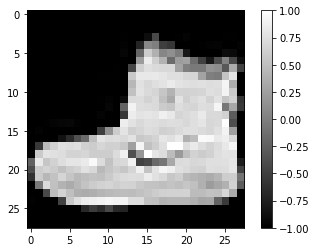

In [12]:
# 첫번째 데이터를 이미지로 출력해보자

plt.imshow(train_x[0].reshape(28, 28), cmap='gray') # 이미지로 출력하려면 채널차원은 없애줘야함
plt.colorbar()
plt.show()

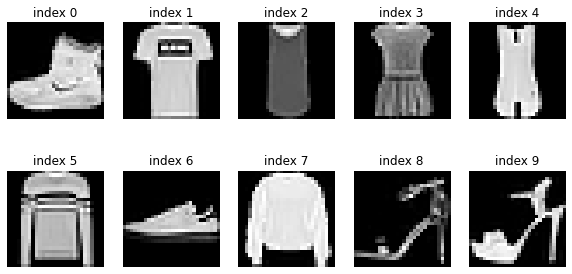

In [17]:
# 좀더 많이 10개정도 띄워보자

plt.figure(figsize=(10, 5)) # 이미지 전체 프레임의 크기

for i in range(10):
    plt.subplot(2, 5, i+1) # 2행 5열의 서브플롯에서 i+1번째에 그린다
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index {i}')
    plt.axis('off') # 이미지의 눈금 지우기
plt.show()

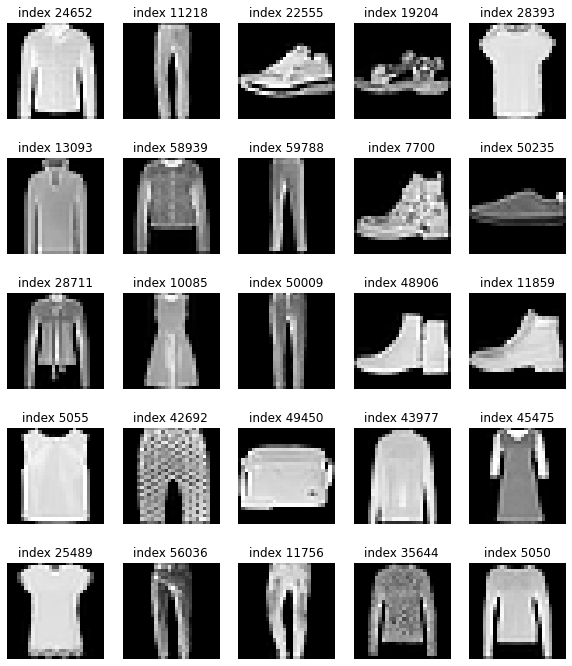

In [19]:
# Q. for 문을 활용해서 이미지 25개를 5x5 의 배열로 띄워보세요. 단, 모든 이미지는 train_images에서 랜덤으로 추출해 보세요.
# (힌트 : numpy에서 랜덤으로 정수를 추출해 주는 함수를 찾아보세요!)


idx = np.random.randint(0, 60000, 25)

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[idx[i]].reshape(28, 28), cmap='gray')
    plt.title(f'index {idx[i]}')
    plt.axis('off') # 이미지의 눈금 지우기

plt.show()

## GAN 모델 생성

In [20]:
BUFFER_SIZE = 60000 # 전체 데이터를 섞기 위해 60,000으로 설정
BATCH_SIZE = 256

- from_tensor_slices() : 리스트, 넘파이, 텐서 자료형에서 데이터셋 생성가능
- 데이터가 잘 섞이게 하기 위해선 버퍼 사이즈를 총 데이터사이즈와 같거나 크게 설정할 것
(버퍼 수 내에서 무작위로 요소가 선택되므로)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
- Conv2DTranspose : Conv2D와 반대로 이미지의 사이즈를 넓혀준다
- 이미지를 (7, 7, 256) → (14, 14, 61) → (28, 28, 1) 키워나간다
- BatchNormalization : 신경망의 가중치가 폭발하지 않도록 가중치 정규화
- 마지막에 tanh 함수 쓰는 이유 : 처음에 이미지를 -1 ~ 1로 정규화 시켰기 때문에 기존 데이터셋과 동일하게 하게 위해


In [24]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    # 이후 레이어에서 Convolution 연산을 할 수 있도록 1차원벡터를 (7, 7, 256)의 3차원 벡터로 변환
    
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(256, kernel_size=5, strides=1, padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [25]:
# 생성모델을 변수에 할당해 생성
generator = make_generator_model()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 256)         1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 256)        

In [26]:
# shape = (1, 100) 형상의 랜덤 노이즈 벡터 생성해 결과물 만들어보자

noise = tf.random.normal([1, 100]) # 가우시안 분포에서 뽑아낸 랜덤 벡터 생성

- 생성자 모델에 인풋으로 노이즈 넣고 바로 모델을 호출하면 결과 이미지 생성된다
- 텐서플로 2.0 이상에서 레이어와 모델에 call 메서드 구현해 놓았기 때문
- 단, 지금은 학습중 아니니 `trainig=False`로 설정해줄 것
- `BatchNormalization`레이어는 학습시기와 추론시기의 행동이 다르기 때문이다

In [27]:
generated_image = generator(noise, training=False)
generated_image.shape

# [1, 28, 28, 1] 사이즈의 이미지가 생성된다

TensorShape([1, 28, 28, 1])

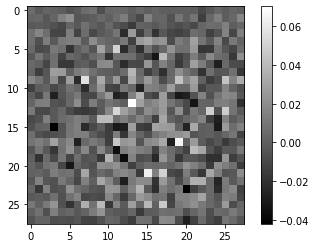

In [28]:
# 생성된 이미지를 시각화해보자
# matplotlib은 2차원 이미지만 보여줄 수 있음, 0,3번째 축 인덱스를 0으로 설정해 (28,28)이미지 꺼내게 한다
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## 판별자 구현하기
---
- Conv2D 층으로 이미지 크기를 점점 줄여나간다
- (28, 28, 1) → (14, 14, 64) → (7, 7, 128)
- 마지막 Flatten에서는 3차원이미지를 1차원으로, 7x7x128=6272 (1,6272) 형상의 벡터로 변환
- 이후 Dense Layer 거쳐 단 하나의 값을 출력

In [29]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[28,28,1]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [30]:
# 판별자 생성
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [31]:
# 아까 생성했던 가짜 이미지를 판별자에 입력하여 결과를 보자
decision = discriminator(generated_image, training=False)
decision

# -0.00230326

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00230326]], dtype=float32)>

## 손실함수와 최적화함수
---
- GAN은 손실함수로 교차 엔트로피(Cross Entropy) 사용
- 교차엔트로피 : 서로 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지 정량적으로 계산할 때 많이 쓰인다
- 판별자는 이미지 구분해야함(2진 클래스 분류) 이진 교차 엔트로피(binary cross entropy)를 사용

- 생성자는 가짜를 진짜라고 판단하게 해야하고 판별자는 가짜를 가짜로, 진짜를 진짜로 잘 판별해야한다
- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것


- tf.keras.losses에서 손실함수에 사용할 교차 엔트로피함수를 사용
- 단, 교차 엔트로피에 사용할 값은 판별자의 판별한 값으로 임의의 실수
- tf.keras.losses의 BinaryCrossEntropy함수는 인풋이 0~1이라고 예측하므로 sigmoid함수를 이용해 정규화
- 정규화는 from_logit=Tru로 설정하면 된다

- `fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- `real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

- tf.ones_like(), tf.zeros_like() 함수를 이용해 위 판별된 값과 같은 벡터를 생성한 후 cross-entropy함수에 넣어 사용

In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss 구현

In [53]:
# generator_loss는 fake_output이 1에 가까워지기를 바라므로 tf.ones_like와의 교차엔트로피 값을 구한다
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # fake_output이 실제에 가까울수록 작은 값을 가진다

### discriminator_loss 구현
- discriminator_loss는 real_output은 1에 가까워지기를, fake_output은 0에 가까워지길 바란다
- real_output은 1로 채워진 벡터와 비교, fake_output은 0으로 채워진 벡터와 비교한다
- 최종 discriminator_loss는 이 둘을 더한 값이다

In [54]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy 구현
- 판별자가 real output, fake output을 얼마나 정확히 판별하는지 accuracy 계산
- real accuracy와 fake accuracy는 1.0 가깝게 정확히 판별한다는 건 생성자가 잘 속이지 못한다는 뜻
- real accuracy와 fake accuracy는 초반에 1.0 가깝게 나오다 서서히 낮아져 둘다 0.5 가까워지는 것이 이상적

real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,  

1. **tf.math.greater_equal(real_output, tf.constant([0.5])** : real_output의 각 원소가 0.5 이상인지 True, False로 판별  
    _tf.Tensor([False, False, True, True])_  
2. **tf.cast( (1), tf.float32 ) :** (1)의 결과가 True이면 1.0, False이면 0.0으로 변환  
    _tf.Tensor([0.0, 0.0, 1.0, 1.0])_  
3. **tf.reduce_mean( (2) )** : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산  
    _0.5_

In [55]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(
        tf.cast(
            tf.math.greater_equal(
                real_output, tf.constant([0.5])), tf.float32))
    
    fake_accuracy = tf.reduce_mean(
        tf.cast(
            tf.math.less(fake_output, tf.constant([0.5])),
                tf.float32))
    
    return real_accuracy, fake_accuracy

### 최적화함수
---
- `learning rate`=0.0001. 조절하여 학습품질을 올려볼 수 있다
- 생성자와 구분자는 따로따로 학습을 진행하는 개별네트워크이지 때문에 optimizer도 따로 만들어주어야 한다


In [56]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [57]:
# 샘플은 한 번에 16장 생성
# 매번 같은 노이즈 생성해야 그에대한 진전과정 확인가능하므로 고정된 seed 노이즈 만들어 둔다
# 100차원의 노이즈를 16개 만든다

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 설계
---
- 데코레이터 : 붙어진 함수 앞뒤로 특정 기능 실행
- @tf.function : 함수 내부적으로 학습 전에 session 열고, 학습 종료시 session 닫아주는 작업 자동으로 해줌

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력  
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산  
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신  
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴  

In [66]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape(persistent=True) as disc_tape: #(3) tf.GradientTape()오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True) # 판별자가 생성된 이미지 판별

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output) # 진짜와 가짜에 대한 판별자의 손실 계산

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = gen_tape.gradient(disc_loss, discriminator.trainable_variables)
    # 판별자의 훈련가능한 변수에 대한 손실의 기울기를 계산
    
    # GradientTape 삭제
    del gen_tape
    del disc_tape
    
    
    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # 판별자의 최적화 기울기를 적용
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [67]:
# 학습현황을 볼 수 있는 샘플을 생성하는 함수
# 16개 seed가 들어있는 sample_seeds 입력받아 만들어낸 prediction을 matplotlib으로 시각화
# plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [68]:
# loss, accuracy 그래프 시각화
# train_step()의 리턴값 :gen_loss, disc_loss, real_accuracy, fake_accuracy
# 위 값을 dict형식 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [69]:
# 정기적으로 모델을 저장하기 위한 checkpoint 생성

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


## 학습시키기

In [70]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [78]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

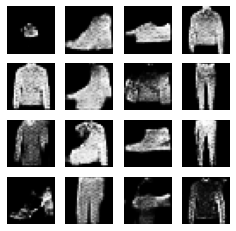

Time for training : 2154 sec


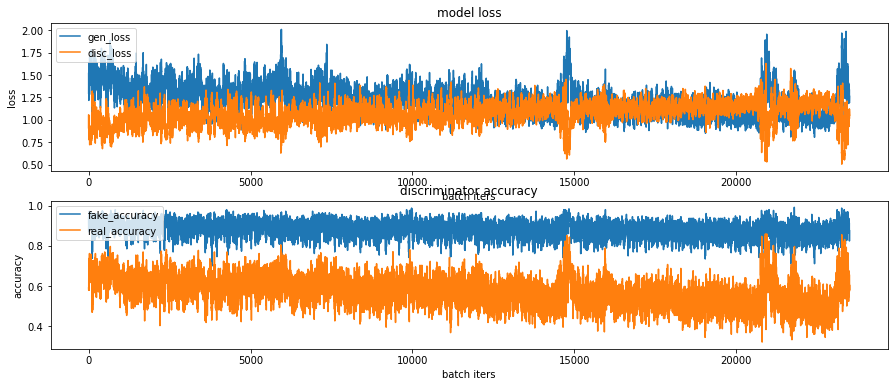

In [79]:
train(train_dataset, EPOCHS, save_every)

In [80]:
# 학습과정 시각화
# 생성한 샘플 이미지를 합쳐 GIF파일로 만든다
# imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식



anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1243311 Sep 20 10:01 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
